In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import torchvision.transforms.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
image_size = 64
mean=0.5
std=0.5
train_transforms = transform=tt.Compose([tt.ToTensor(),
                                         tt.Normalize(mean,std)])

train_data = MNIST(root=".", train=True, download=True, transform=train_transforms)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [3]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [4]:
def denormalize(images, means, stds):
    return images * stds + means

def show_batch(loader):
    for images, labels in loader:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, mean,std)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([64, 1, 28, 28])


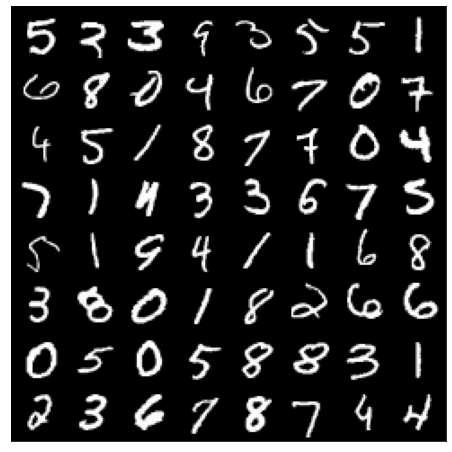

In [5]:
show_batch(train_loader)

# Handling the GPU

In [6]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device) 
    
    def __len__(self):
        return len(self.dataloader)

In [7]:
device = get_default_device()
print('device: ', device)

train_loader = DeviceDataLoader(train_loader, device)

device:  cuda


# Discriminator

The Discriminator works like any other CNN. It takes a real image and tries to classify if it is real or fake (generated). Therefore, we will be using the sigmoid activation function in the output layer

In [8]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2, inplace=True)]
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim, d_output_dim):
        super(Discriminator, self).__init__()
        self.conv1 = conv_block(d_input_dim, d_output_dim, 4, 2, 1)
        self.conv2 = conv_block(d_output_dim, d_output_dim*2, 4, 2 ,1)
        self.conv3 = conv_block(d_output_dim*2, d_output_dim*4, 3 ,2 ,1)
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=d_output_dim*4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid())

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [10]:
discriminator = Discriminator(1, 32)
discriminator = to_device(discriminator, device)

# Generator

In [11]:
def deconv_block(in_channels, out_channels, kernel_size, stride, padding):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
               nn.ReLU(True)]
    return nn.Sequential(*layers)

In [12]:
# g_input_dim = nz = length of the z input vector
# g_output_dim = ngf = size of the feature maps that are propagated through the generator
# d_input_dim = nc = nc is the number of channels in the output image (set to 3 for RGB images)

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim, d_input_dim):
        super(Generator, self).__init__()       
        self.deconv1 = deconv_block(g_input_dim, g_output_dim*4, 4, 1, 0)
        self.deconv2 = deconv_block(g_output_dim*4, g_output_dim*2, 3, 2 ,1)
        self.deconv3 = deconv_block(g_output_dim*2, g_output_dim, 4, 2 ,1)
        self.output = nn.Sequential(
            nn.ConvTranspose2d(in_channels=g_output_dim, out_channels=d_input_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
    
    # forward method
    def forward(self, x): 
        out = self.deconv1(x)
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.output(out)
        return out

In [13]:
latent_size = 128
generator = Generator(latent_size, 32, 1)
generator = to_device(generator, device)

In [14]:
x = torch.randn(batch_size, latent_size, 1, 1).to(device) #random latent tensors
fake_images = generator(x)
print(fake_images.shape)

torch.Size([64, 1, 28, 28])


In [15]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(8,8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

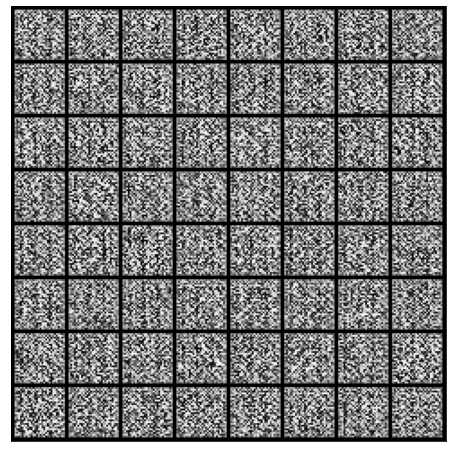

In [16]:
img_grid_fake = make_grid(fake_images[:64], normalize=True)
show(img_grid_fake)

# Discriminator Training

In [17]:
criterion = nn.BCELoss() 

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device) # real images are labeled 1
    real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device) # fake images are labeled 0
    fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [18]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device) # fake targets are now 1 instead of 0
    loss = criterion(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

# Full Training Loop

In [19]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_filename = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images, mean, std), os.path.join(sample_dir, fake_filename))
    print('Saving', fake_filename)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

Saving generated-images-0000.png


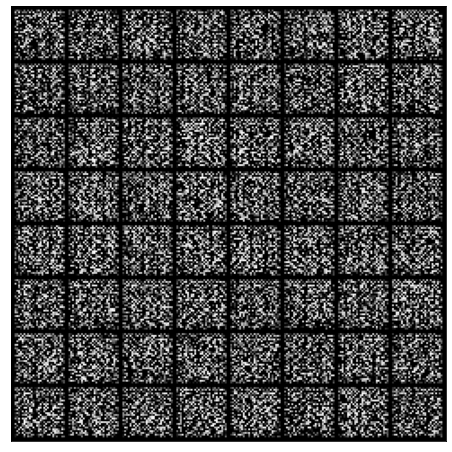

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

save_samples(0, fixed_latent)

In [22]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [23]:
lr = 0.0002
epochs = 50

history = fit(epochs, lr)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 1.9001, loss_d: 0.5119, real_score: 0.6633, fake_score: 0.0516
Saving generated-images-0001.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.7474, loss_d: 1.1009, real_score: 0.4176, fake_score: 0.0189
Saving generated-images-0002.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 1.5146, loss_d: 0.4038, real_score: 0.9117, fake_score: 0.2534
Saving generated-images-0003.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.4023, loss_d: 0.5291, real_score: 0.8697, fake_score: 0.3004
Saving generated-images-0004.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 1.6338, loss_d: 0.5474, real_score: 0.7596, fake_score: 0.2053
Saving generated-images-0005.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.2647, loss_d: 0.6470, real_score: 0.9411, fake_score: 0.4111
Saving generated-images-0006.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.4667, loss_d: 0.3408, real_score: 0.7914, fake_score: 0.0795
Saving generated-images-0007.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.2860, loss_d: 0.3633, real_score: 0.9598, fake_score: 0.2471
Saving generated-images-0008.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 1.8474, loss_d: 0.3965, real_score: 0.8002, fake_score: 0.1317
Saving generated-images-0009.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.2552, loss_d: 0.3496, real_score: 0.8167, fake_score: 0.1146
Saving generated-images-0010.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.5414, loss_d: 0.4535, real_score: 0.9573, fake_score: 0.3074
Saving generated-images-0011.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 0.5853, loss_d: 0.7666, real_score: 0.5440, fake_score: 0.0543
Saving generated-images-0012.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.0837, loss_d: 0.2691, real_score: 0.8954, fake_score: 0.1326
Saving generated-images-0013.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.4386, loss_d: 0.8141, real_score: 0.9923, fake_score: 0.5140
Saving generated-images-0014.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.4522, loss_d: 0.3541, real_score: 0.9146, fake_score: 0.2086
Saving generated-images-0015.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.2899, loss_d: 0.4543, real_score: 0.8112, fake_score: 0.1830
Saving generated-images-0016.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 1.6852, loss_d: 0.4027, real_score: 0.7271, fake_score: 0.0567
Saving generated-images-0017.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.1255, loss_d: 0.3048, real_score: 0.8532, fake_score: 0.1166
Saving generated-images-0018.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.6516, loss_d: 0.7716, real_score: 0.5632, fake_score: 0.0496
Saving generated-images-0019.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.4508, loss_d: 0.4792, real_score: 0.9495, fake_score: 0.3049
Saving generated-images-0020.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 0.7365, loss_d: 0.3467, real_score: 0.7873, fake_score: 0.0414
Saving generated-images-0021.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.6149, loss_d: 0.4472, real_score: 0.9649, fake_score: 0.2962
Saving generated-images-0022.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 2.1682, loss_d: 0.2161, real_score: 0.8990, fake_score: 0.0928
Saving generated-images-0023.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.0582, loss_d: 0.2504, real_score: 0.9009, fake_score: 0.1224
Saving generated-images-0024.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.5641, loss_d: 0.3763, real_score: 0.8893, fake_score: 0.2063
Saving generated-images-0025.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.2607, loss_d: 0.2646, real_score: 0.9551, fake_score: 0.1764
Saving generated-images-0026.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.0387, loss_d: 0.2588, real_score: 0.9170, fake_score: 0.1377
Saving generated-images-0027.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 2.2793, loss_d: 0.1445, real_score: 0.9168, fake_score: 0.0504
Saving generated-images-0028.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 2.6116, loss_d: 0.3687, real_score: 0.9715, fake_score: 0.2537
Saving generated-images-0029.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.8086, loss_d: 1.2487, real_score: 0.9986, fake_score: 0.6474
Saving generated-images-0030.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 2.4794, loss_d: 0.2982, real_score: 0.9459, fake_score: 0.1963
Saving generated-images-0031.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.4658, loss_d: 0.1141, real_score: 0.9193, fake_score: 0.0255
Saving generated-images-0032.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.8439, loss_d: 0.1384, real_score: 0.9348, fake_score: 0.0620
Saving generated-images-0033.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 0.9604, loss_d: 0.4150, real_score: 0.7307, fake_score: 0.0540
Saving generated-images-0034.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 1.8176, loss_d: 0.1962, real_score: 0.9743, fake_score: 0.1428
Saving generated-images-0035.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.1811, loss_d: 0.2026, real_score: 0.9589, fake_score: 0.1357
Saving generated-images-0036.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.7260, loss_d: 0.0674, real_score: 0.9613, fake_score: 0.0259
Saving generated-images-0037.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.8658, loss_d: 0.1023, real_score: 0.9629, fake_score: 0.0589
Saving generated-images-0038.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.4427, loss_d: 0.1219, real_score: 0.9462, fake_score: 0.0590
Saving generated-images-0039.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.4280, loss_d: 0.8469, real_score: 0.5048, fake_score: 0.0251
Saving generated-images-0040.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.5087, loss_d: 0.3093, real_score: 0.9140, fake_score: 0.1724
Saving generated-images-0041.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 0.8539, loss_d: 0.7393, real_score: 0.5587, fake_score: 0.0127
Saving generated-images-0042.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.3382, loss_d: 0.0936, real_score: 0.9273, fake_score: 0.0146
Saving generated-images-0043.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 1.1787, loss_d: 0.4178, real_score: 0.7362, fake_score: 0.0396
Saving generated-images-0044.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.9708, loss_d: 0.2064, real_score: 0.8635, fake_score: 0.0418
Saving generated-images-0045.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.2684, loss_d: 0.5382, real_score: 0.6462, fake_score: 0.0246
Saving generated-images-0046.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 1.4503, loss_d: 0.2484, real_score: 0.8341, fake_score: 0.0419
Saving generated-images-0047.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.3770, loss_d: 0.2681, real_score: 0.8892, fake_score: 0.1152
Saving generated-images-0048.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.9217, loss_d: 0.0703, real_score: 0.9525, fake_score: 0.0179
Saving generated-images-0049.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 2.6175, loss_d: 0.3768, real_score: 0.7458, fake_score: 0.0098
Saving generated-images-0050.png


In [24]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Text(0.5, 1.0, 'Losses')

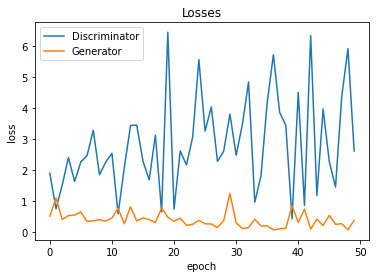

In [25]:
plt.plot(history[0], '-')
plt.plot(history[1], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

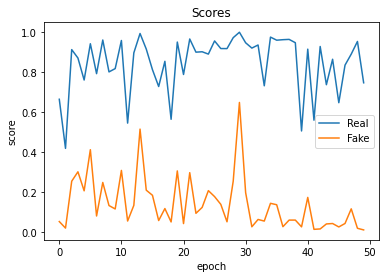

In [26]:
plt.plot(history[2], '-')
plt.plot(history[3], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

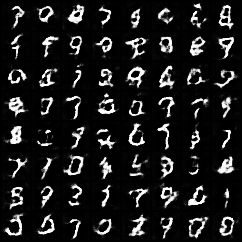

In [27]:
from IPython.display import Image

Image('./generated/generated-images-0001.png')

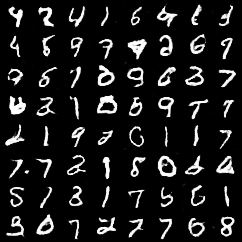

In [28]:
Image('./generated/generated-images-0010.png')

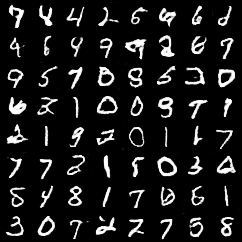

In [29]:
Image('./generated/generated-images-0020.png')

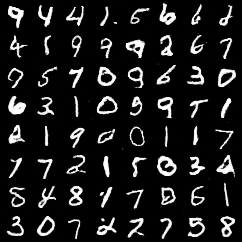

In [30]:
Image('./generated/generated-images-0030.png')

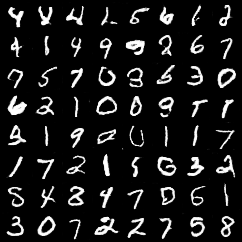

In [31]:
Image('./generated/generated-images-0040.png')

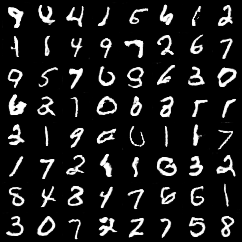

In [32]:
Image('./generated/generated-images-0050.png')

In [33]:
!pip install natsort

In [34]:
import imageio
import natsort
from glob import glob


images = glob('./generated/' + '*.png')
images = natsort.natsorted(images)
frames = []

for image in images:
    frames.append(imageio.imread(image))
imageio.mimsave('./result.gif', frames, fps=5)